In [1]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-njroe6pg because the default path (/home/ats_sc_user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# of x and z coordinates: 101, 101
0.0 1000.0
95.25741268224333 11.920292202211769
# of cells: 100
slope:  -0.08333712048003156


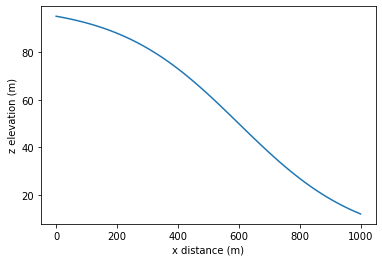

In [4]:
# Specify the top surface, given by z(x).
#
# 1 km long hillslope, 10% slope, 100 cells (or 101 nodes) in x.
x = np.linspace(0,1000,101)
z = 100*(1-1/(1+np.exp(-(x-600)/200)))
print(f'# of x and z coordinates: {len(x)}, {len(z)}')
print(x[0],x[100])
print(z[0],z[100])

# plot the surface topography
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')

# make the (manifold) 2D mesh.
m2 = meshing_ats.Mesh2D.from_Transect(x,z)
print(f'# of cells: {m2.num_cells()}')

print("slope: ",(z[100]-z[0])/(x[100]-x[0]))

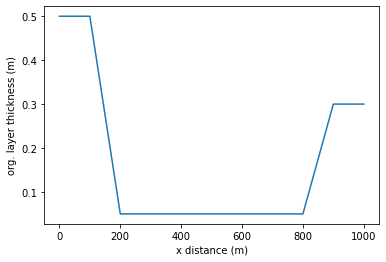

In [7]:
# In this mesh, we vary the organic layer thickness across the hillslope.
#
# Changing organic layer thickness 
def organic_thickness(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    if x < 100:
        thickness = 0.5
    elif ((100 <= x) and (x <= 200)):
        thickness = -0.0045*x + 0.95
    elif ((200 < x) and (x < 800)):
        thickness = 0.05
    elif ((800 <= x) and (x <= 900)):
        thickness = 0.0025*x - 1.95
    else:
        thickness = 0.3
    return thickness

org_layer_thickness = np.array([organic_thickness(xx) for xx in m2.coords[:,0]])
plt.plot(x, org_layer_thickness[0:101]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');

In [8]:
# geometry of the transect extrusion
transect_layer_types = []
transect_layer_data = []
transect_layer_ncells = []

depth = []  # bookkeeping for material IDs
current_depth = 0

# We use the same dz as the above column, but because the material ID will change
# at a given depth in x, we spell it out with 1 cell per transect.
#
# 10 cells @ 5cm
dz = .05
depth.append(current_depth)
for i in range(10):
    transect_layer_types.append('constant')
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)
    
# grow dz by factors of 2, til we hit 2m
i = 0
while current_depth < 2:
    dz *= 2
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)

# 2m cells to 40m
dz = 2
while current_depth < 40:
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)


In [9]:
# calculate the cell centroid depth
depth = np.array(depth)
transect_layer_depth = (depth[0:-1] + depth[1:])/2

# allocate 2D matrix for material id, (# surface cells, # layers)
n_layers = len(transect_layer_data)
transect_layer_mat_ids=np.zeros((n_layers, m2.num_cells()), 'i')
for j in range(m2.num_cells()):
    for i in range(n_layers):
        if (transect_layer_depth[i] < org_layer_thickness[j]):
            transect_layer_mat_ids[i,j] = 1001
        elif transect_layer_depth[i] < 2:
            transect_layer_mat_ids[i,j] = 1002
        else:
            transect_layer_mat_ids[i,j] = 999


In [10]:
# print out the layer information for the first column of cells
meshing_ats.summarize_extrusion(transect_layer_types, transect_layer_data, 
                                transect_layer_ncells, transect_layer_mat_ids, 0)

Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	| 1001 	|   0.050000 	|   0.000000
 01 	| 01 	| 1001 	|   0.050000 	|   0.050000
 02 	| 02 	| 1001 	|   0.050000 	|   0.100000
 03 	| 03 	| 1001 	|   0.050000 	|   0.150000
 04 	| 04 	| 1001 	|   0.050000 	|   0.200000
 05 	| 05 	| 1001 	|   0.050000 	|   0.250000
 06 	| 06 	| 1001 	|   0.050000 	|   0.300000
 07 	| 07 	| 1001 	|   0.050000 	|   0.350000
 08 	| 08 	| 1001 	|   0.050000 	|   0.400000
 09 	| 09 	| 1001 	|   0.050000 	|   0.450000
 10 	| 10 	| 1002 	|   0.100000 	|   0.500000
 11 	| 11 	| 1002 	|   0.200000 	|   0.600000
 12 	| 12 	| 1002 	|   0.400000 	|   0.800000
 13 	| 13 	| 1002 	|   0.800000 	|   1.200000
 14 	| 14 	|  999 	|   2.000000 	|   2.000000
 15 	| 15 	|  999 	|   2.000000 	|   4.000000
 16 	| 16 	|  999 	|   2.000000 	|   6.000000
 17 	| 17 	|  999 	|   2.000000 	|   8.000000
 1

In [11]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, transect_layer_types,transect_layer_data, 
                                        transect_layer_ncells, transect_layer_mat_ids)
if os.path.exists('transect-sigmoid.exo'):
    os.remove('transect-sigmoid.exo')
m3.write_exodus('transect-sigmoid.exo')


You are using exodus.py v 1.20.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: transect-sigmoid.exo
Closing exodus file: transect-sigmoid.exo


In [12]:
# Now convert the file from "polyhedral" to "fixed format" and open it in VisIt or Paraview.
os.system("$AMANZI_TPLS_DIR/bin/meshconvert transect-sigmoid.exo transect-sigmoid_fixed_format.exo")


App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0